## Exploration of Stylometry Algorithms

Based on the Programming Historian guide [here](https://programminghistorian.org/en/lessons/introduction-to-stylometry-with-python#the-software)

### Data

The class corpus. TODO: fill in more detail here. Also, we focus on the Eddard and Joffrey authored texts later. These refer to Muller's and Trump's tweets respectively.

In [1]:
import os

In [2]:
os.getcwd()

'/Users/ratan/personal/ms/dhsi/data/class_corpus'

### Get Corpus Metadata

- All texts are in files names `<author>_<name>.txt`
- Extract this author name and filename from this list

In [159]:
def get_all():
    for filename in filter(lambda x: not x.startswith('.'), os.listdir('corpus')):
        with open(os.path.join('corpus', filename), 'r') as f:
            yield (filename, "\n".join(f))

In [160]:
all_files = dict(get_all())

### Tokenize And Count

- Tokenize the texts in the corpus
- Get the frequency distribution of the word counts

In [5]:
import nltk
%matplotlib inline

In [93]:
tokens_by_filename = dict()
token_sizes_by_filename = dict()
for key in all_files:
    tokens = nltk.word_tokenize(all_files[key])
    token_sizes_by_filename[key] = [len(t) for t in tokens if any(c.isalpha() for c in t)]
    tokens_by_filename[key] = [t for t in tokens if any(c.isalpha() for c in t)]

In [86]:
filenames_by_author = dict()
for k in all_files:
    if filenames_by_author.get(k.split('_')[0]):
        filenames_by_author[k.split('_')[0]].append(k)
    else:
        filenames_by_author[k.split('_')[0]] = [k]


### Meddenhall's Characteristic Curves of Composition

Plot the frequency distribution of word lengths.

Are word lengths characteristic of composers/composition?

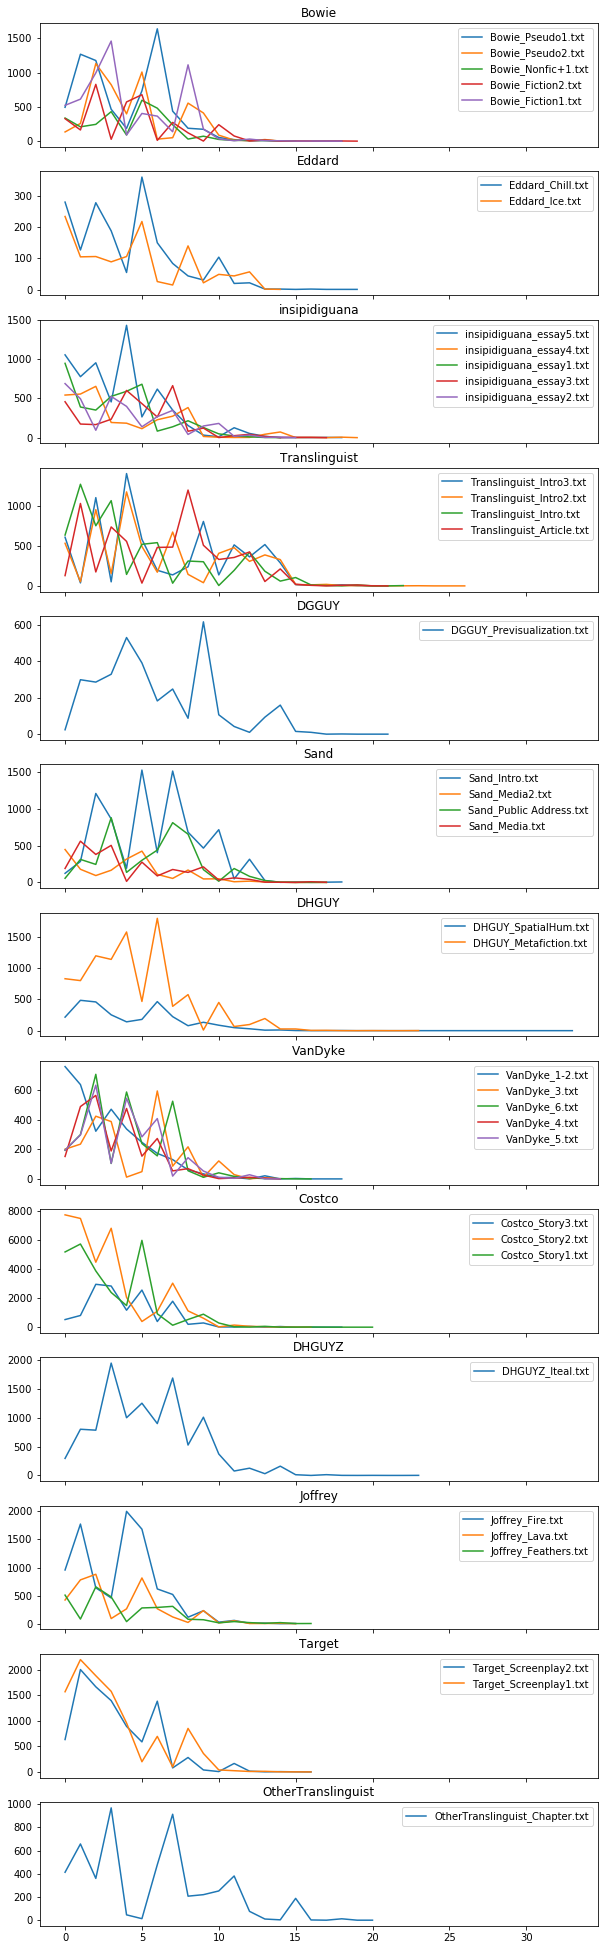

In [161]:
import matplotlib.pyplot as plt
import numpy as np

num_authors = 3

from random import shuffle

all_authors = list(filenames_by_author.keys())

fig, axes = plt.subplots(
    len(all_authors), 1, 
    figsize=(10, 35), 
    sharex=True)

for i, (ax, author) in enumerate(zip(axes, all_authors)):
    for title in filenames_by_author[author]:
        xy = np.array(list(enumerate(
            nltk.FreqDist(token_sizes_by_filename[title]).values())))
        x=xy[:, 0]
        y=xy[:, 1]
        ax.plot(x, y, label=title)
        ax.legend()
        ax.set_title(author)

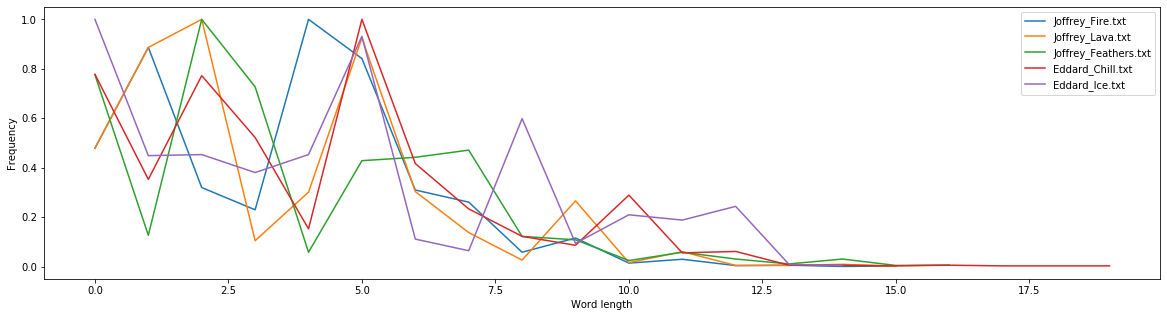

In [170]:
joffrey_and_eddard_files = [('Joffrey', 'blue'), ('Eddard', 'orange')]

fig, ax = plt.subplots(1,1,figsize=(20,5))

for (author, color) in joffrey_and_eddard_files:
    for file in filenames_by_author[author]:
        xy = np.array(list(enumerate(
            nltk.FreqDist(token_sizes_by_filename[file]).values())))
        x=xy[:, 0]
        y=xy[:, 1]
        y = y / np.max(y)
        ax.plot(x, y, label=file)
        ax.set_xlabel('Word length')
        ax.set_ylabel('Frequency')

ax.legend()

### Kilgariff's Chi-Squared Method

Text similarity characterized by [chi-square distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html) between word count frequencies (normalized by total word count).

In [163]:
def joint_vocabulary(authors, size=500):
    tokens = []
    for author in authors:
        for file in filenames_by_author[author]:
            tokens += tokens_by_filename[file]
    vocab = nltk.FreqDist(tokens)
    return vocab
    
interesting_authors = ['Joffrey', 'Eddard']
voc = joint_vocabulary(interesting_authors, 500)

In [164]:
distribution_in_full_corpus = voc.most_common(500)
codebook = [i for (i, _) in distribution_in_full_corpus]

In [165]:
def feature_vector(title, codebook_):
    tokens = tokens_by_filename[title]
    freq_dist = nltk.FreqDist(tokens)
    total_tokens = len(tokens)
    for tok in codebook_:
        yield freq_dist[tok]/total_tokens if freq_dist[tok] > 0 else 0.01

In [166]:
feature_vectors = dict()

for author in interesting_authors:
    for title in filenames_by_author[author]:
        feature_vectors[title] = list(feature_vector(title, codebook))


In [167]:
import scipy

csqs = np.zeros((len(list(feature_vectors.keys())),
                 len(list(feature_vectors.keys()))))
for i, x_title in enumerate(feature_vectors):
    for j, y_title in enumerate(feature_vectors):
        fv1 = feature_vectors[x_title]
        fv2 = feature_vectors[y_title]
        csq, _ = scipy.stats.chisquare(fv1, fv2)
        csqs[i, j] = csq
    

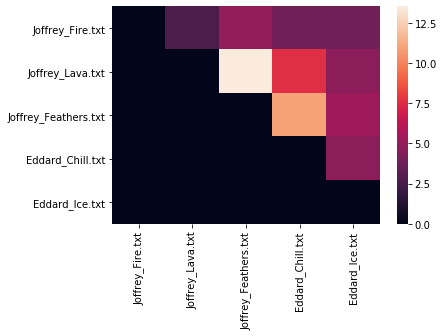

In [168]:
import seaborn as sns

sns.heatmap(np.triu(csqs), 
            xticklabels=list(feature_vectors.keys()), 
            yticklabels=list(feature_vectors.keys()))

### Conclusion

- Mendenhall's Curves: 
    - show a distinction between Trump's speeches and tweets.
    - do not show much of difference between Trump and Muller's texts
    - problematic because asessing curve symmetry is subjective
- Kilgariff's Method:
    - provides an easy way to compare
    - doesn't seem very effective at distinguishing authors